In [1]:
# %%
import argparse
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F

In [2]:
# parse arguments
parser = argparse.ArgumentParser(description='Imbalanced MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
parser.add_argument('--nrow', type=int, default=5,
                    help='rows of example')
parser.add_argument('--ncol', type=int, default=10,
                    help='columns of example')
parser.add_argument('-f')


args = parser.parse_args()

torch.manual_seed(args.seed)

In [3]:
# %%
imbalanced_linear_train_dataset = torch.load('imbalanced_linear_train_dataset.pt')
imbalanced_linear_train_loader = torch.utils.data.DataLoader(imbalanced_linear_train_dataset, batch_size=args.batch_size, shuffle=True)

imbalanced_step_train_dataset = torch.load('imbalanced_step_train_dataset.pt')
imbalanced_step_train_loader = torch.utils.data.DataLoader(imbalanced_step_train_dataset, batch_size=args.batch_size, shuffle=True)

In [4]:
# %%
test_dataset = torch.load('test_dataset.pt')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=True)

In [5]:
# %%
import matplotlib.pyplot as plt

import seaborn as sns


def show_mnist(arr, nrow=args.nrow, ncol=args.ncol, figsize=None):
    
    if figsize is None:
        figsize = (ncol, nrow)
        
    f, a = plt.subplots(nrow, ncol, figsize=figsize)
    
    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')
    
    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))
            
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()
    plt.savefig('examples.png')

In [6]:
#Getting Whole Test Dataset

X_test_dataset = []
y_test_dataset = []
for image, label in test_loader:
    for l in label:
        y_test_dataset.append(l.item())
    for i in image:
        X_test_dataset.append(i[0].reshape(1, -1).numpy()[0])

In [7]:
#Getting Whole Training Datasets

X_train_lin_dataset = []
y_train_lin_dataset = []
for image, label in imbalanced_linear_train_loader:
    for l in label:
        y_train_lin_dataset.append(l.item())
    for i in image:
        X_train_lin_dataset.append(i[0].reshape(1, -1).numpy()[0])
        
X_train_step_dataset = []
y_train_step_dataset = []
for image, label in imbalanced_step_train_loader:
    for l in label:
        y_train_step_dataset.append(l.item())
    for i in image:
        X_train_step_dataset.append(i[0].reshape(1, -1).numpy()[0])

In [8]:
#Random Forest

import pandas as pd

X_lin = X_train_lin_dataset
y_lin = y_train_lin_dataset
X_step = X_train_step_dataset
y_step = y_train_step_dataset

for i in range(len(y_lin)):
    if y_lin[i] == 0:
        y_lin[i] = 0
    else:
        y_lin[i] = 1
        
for i in range(len(y_step)):
    if y_step[i] == 0:
        y_step[i] = 0
    else:
        y_step[i] = 1
        
X_lin = pd.DataFrame(X_lin)
y_lin = pd.DataFrame(y_lin)
X_step = pd.DataFrame(X_step)
y_step = pd.DataFrame(y_step)

In [9]:
from sklearn.model_selection import train_test_split

X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(X_lin, y_lin, train_size = 0.67, random_state = 42, stratify = y_lin)
X_lin_train, X_step_test, y_step_train, y_step_test = train_test_split(X_step, y_step, train_size = 0.67, random_state = 42, stratify = y_step)

In [10]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import mean_squared_error

def cross_validate_single_model(model, X, y, n_folds, args):
    
    performance = 0
    
    if model.endswith("classifier"):
        splitter = StratifiedKFold(n_splits=n_folds, shuffle=True).split(X,y)
    elif model.endswith("regressor"):
        splitter =           KFold(n_splits=n_folds, shuffle=True).split(X)
        
    for train_index, test_index in splitter:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

        #mean imputation
        mean_imputer = SimpleImputer()
        X_train      = mean_imputer.fit_transform(X_train)
        X_test       = mean_imputer.    transform(X_test)
        
        ##train/test
        if model   == "dt_classifier":
            model_ = DecisionTreeClassifier(**args)
            
        elif model == "dt_regressor":
            model_ = DecisionTreeRegressor (**args)
            
        elif model == "rf_classifier":
            model_ = RandomForestClassifier(**args)
            
        elif model == "rf_regressor":
            model_ = RandomForestRegressor (**args)
            
        model_.fit(X_train, y_train)
        pred   = model_.predict(X_test)
        
        if  model.endswith("classifier"):
            performance_contrib = roc_auc_score(y_test, pred)/n_folds
        elif model.endswith("regressor"):
            performance_contrib = mean_squared_error(y_test, pred)/n_folds

        
        performance += performance_contrib
    
    return performance

In [11]:
from joblib import Parallel, delayed
import multiprocessing 
from itertools import product

num_processes = 20

def cross_validate_models(model, X, y, n_folds, args):
    
    for key in args.keys():
        if len(args[key])==0:
            args[key]=[1]
            
    arg_dict_vec = [dict(zip(args.keys(), values))\
                    for values in product(*args.values())]

    
    results = Parallel(n_jobs=num_processes)\
              (delayed(cross_validate_single_model)\
              (model, X, y, n_folds, arg_dict)\
              for arg_dict in arg_dict_vec)
    
    names   = [name_creator("", n_folds, arg_dict)\
              for arg_dict in arg_dict_vec]
    
    auc_dict = dict(zip(names, results))
        
    return auc_dict

In [12]:
import os

rslt_addr = "./results/"
if not os.path.exists(rslt_addr):
    os.makedirs(rslt_addr)

In [13]:
def name_creator(model,n_folds, args):

    name = "model_%s__n_folds_%d"%(model, n_folds)
    
    def describe_in_string(vec):
        
        if not isinstance(vec, list):
            return vec
        
        if len(vec)==0:
            return "NA"
        
        if isinstance(vec[0], str):
            return '_'.join(vec)
    
        if len(vec)==1:
            return "%d"%vec[0]
    
        return "%d_%d"%(np.min(vec), np.max(vec))
    
    for arg in sorted(args.keys()):
            name += "__%s_%s"%(arg, describe_in_string(args[arg]))
    
    return name

In [14]:
import pickle
import os
import numpy as np

def cross_validate_args (model, X, y, n_folds, args):
    
    rslt_dict_name = name_creator(model, n_folds, args)
    rslt_dict_addr = os.path.join(rslt_addr, rslt_dict_name)
    
    
    if os.path.isfile(rslt_dict_addr):
        with open(rslt_dict_addr,"rb") as rslt_dict_handle:
            rslt_dict = pickle.load(rslt_dict_handle)
    else:
        rslt_dict = cross_validate_models(model, X, y, n_folds, args)
        with open(rslt_dict_addr,"wb") as rslt_dict_handle:
            pickle.dump(rslt_dict, rslt_dict_handle)

    return rslt_dict

In [15]:
#Linear

In [16]:
n_folds    = 10
args       = {"criterion" : ["entropy"],\
              "max_depth" : [10]}

rf_entropy_lin_vals = cross_validate_args ("rf_classifier", X_lin, y_lin, n_folds, args)
rf_entropy_lin_list = []
val = 'model___n_folds_10__criterion_entropy__max_depth_' + str(10)
rf_entropy_lin_list.append(rf_entropy_lin_vals[val])

In [17]:
for i in range(len(y_test_dataset)):
    if y_test_dataset[i] == 0:
        y_test_dataset[i] = 0
    else:
        y_test_dataset[i] = 1

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

rfc_lin = RandomForestClassifier(n_estimators=10, random_state=1)

rfc_lin.fit(X_train_lin_dataset, y_train_lin_dataset)

y_pred = rfc_lin.predict_proba(X_test_dataset)[:,1]

lin_auroc = roc_auc_score(y_true = y_test_dataset, y_score = y_pred, multi_class = 'ovr')
print("Linear AUROUC: " + str(lin_auroc))

Linear AUROUC: 0.9991893863975745


In [18]:
#Step

In [19]:
n_folds    = 10
args       = {"criterion" : ["entropy"],\
              "max_depth" : [10]}

rf_entropy_step_vals = cross_validate_args ("rf_classifier", X_step, y_step, n_folds, args)
rf_entropy_step_list = []
val = 'model___n_folds_10__criterion_entropy__max_depth_' + str(10)
rf_entropy_step_list.append(rf_entropy_step_vals[val])

In [20]:
for i in range(len(y_test_dataset)):
    if y_test_dataset[i] == 0:
        y_test_dataset[i] = 0
    else:
        y_test_dataset[i] = 1

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

rfc_step = RandomForestClassifier(n_estimators=10, random_state=1)

rfc_step.fit(X_train_step_dataset, y_train_step_dataset)

y_pred = rfc_step.predict_proba(X_test_dataset)[:,1]

step_auroc = roc_auc_score(y_true = y_test_dataset, y_score = y_pred, multi_class = 'ovr')
print("Step AUROC: " + str(step_auroc))

Step AUROC: 0.9986301416353681


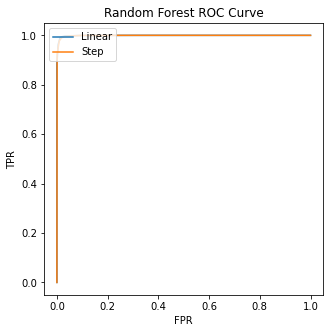

In [21]:
#Plot ROC Curve
from sklearn.metrics import roc_curve

lin_score = rfc_lin.predict_proba(X_test_dataset)[:,1]
step_score = rfc_step.predict_proba(X_test_dataset)[:,1]

fpr1, tpr1, th1 = roc_curve(y_test_dataset, lin_score)
fpr2, tpr2, th2 = roc_curve(y_test_dataset, step_score)

plt.subplots(figsize=(5, 5))
plt.title('Random Forest ROC Curve')
plt.plot(fpr1, tpr1, label = "Linear")
plt.plot(fpr2, tpr2, label = "Step")
plt.legend(loc="upper left")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig('rf_linear_step_roc_curve.png')
plt.show()

In [22]:
from joblib import dump, load

dump(rfc_lin, 'rf_linear.joblib')
dump(rfc_step, 'rf_step.joblib')

['rf_step.joblib']

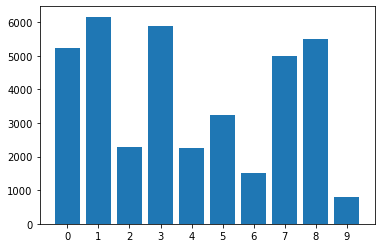

In [23]:
#print('Distribution of classes in linear imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_linear_train_loader.dataset.train_labels, return_counts=True)
num_classes = 10
classe_labels = range(num_classes)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.savefig('dist linear.png')
plt.show()

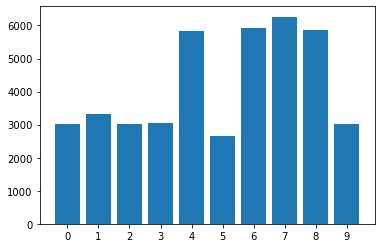

In [24]:
#print('Distribution of classes in step imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_step_train_loader.dataset.train_labels, return_counts=True)
num_classes = 10
classe_labels = range(num_classes)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.savefig('dist step.png')
plt.show()

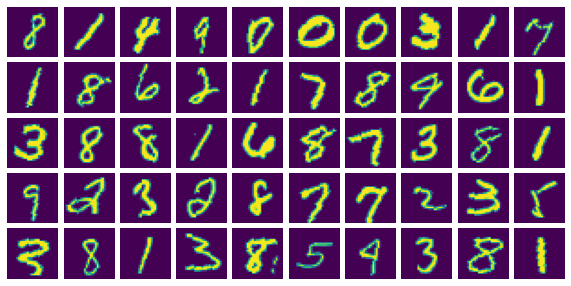

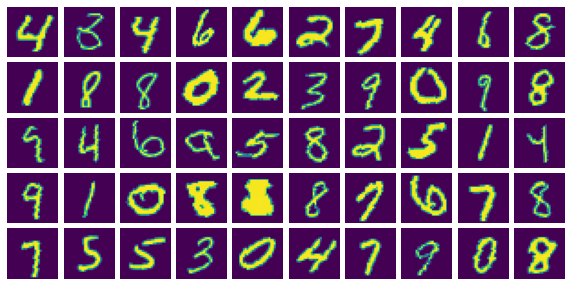

In [25]:
# %%
for data, _ in imbalanced_linear_train_loader:
    show_mnist(data)
    break
    
for data, _ in imbalanced_step_train_loader:
    show_mnist(data)
    break